## Graph Convolutions For SIDER +OFFSIDES

Featurization=ConvMolFeaturizer

É utilizado com modelos GraphConvModel.

Alternativamente, também implementamos este modelo (GraphConvModel) usando layers do TensorGraph

In [196]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import numpy as np
import tensorflow as tf
import deepchem as dc
import pandas as pd
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel


import warnings
warnings.filterwarnings('ignore')

In [197]:
"""
OFFSIDES dataset loader.
"""
from __future__ import division
from __future__ import unicode_literals

import os
import logging
import deepchem

logger = logging.getLogger(__name__)


def load_sider_offsides(featurizer='ECFP', split='index', reload=True, K=4):
  logger.info("About to load sider offsides dataset.")
  data_dir = deepchem.utils.get_data_dir()
  if reload:
    save_dir = os.path.join(data_dir, "sideroffsides/" + featurizer + "/" + str(split))

  dataset_file = os.path.join("/home/mamonteiro/source-code/Project-LEI/sider+offsides/", "sider+offsides_combined.csv.gz")


  dataset = deepchem.utils.save.load_from_disk(dataset_file)
  logger.info("Columns of dataset: %s" % str(dataset.columns.values))
  logger.info("Number of examples in dataset: %s" % str(dataset.shape[0]))
  SIDER_OFFSIDES_tasks = dataset.columns.values[1:].tolist()

  if reload:
    loaded, all_dataset, transformers = deepchem.utils.save.load_dataset_from_disk(
        save_dir)
    if loaded:
      return SIDER_OFFSIDES_tasks, all_dataset, transformers

  # Featurize OFFSIDES dataset
  logger.info("About to featurize SIDER OFFSIDES dataset.")
  if featurizer == 'ECFP':
    featurizer = deepchem.feat.CircularFingerprint(size=1024)
  elif featurizer == 'GraphConv':
    featurizer = deepchem.feat.ConvMolFeaturizer()
  elif featurizer == 'Weave':
    featurizer = deepchem.feat.WeaveFeaturizer()
  elif featurizer == 'Raw':
    featurizer = deepchem.feat.RawFeaturizer()

  logger.info("SIDER OFFSIDES tasks: %s" % str(SIDER_OFFSIDES_tasks))
  logger.info("%d tasks in total" % len(SIDER_OFFSIDES_tasks))

  loader = deepchem.data.CSVLoader(
      tasks=SIDER_OFFSIDES_tasks, smiles_field="smiles", featurizer=featurizer)
  dataset = loader.featurize(dataset_file)
  logger.info("%d datapoints in SIDER OFFSIDES dataset" % len(dataset))

  # Initialize transformers
  transformers = [
      deepchem.trans.BalancingTransformer(transform_w=True, dataset=dataset)
  ]
  logger.info("About to transform data")
  for transformer in transformers:
    dataset = transformer.transform(dataset)

  if split == None:
    return SIDER_OFFSIDES_tasks, (dataset, None, None), transformers

  splitters = {
      'index': deepchem.splits.IndexSplitter(),
      'random': deepchem.splits.RandomSplitter(),
      'scaffold': deepchem.splits.ScaffoldSplitter(),
      'task': deepchem.splits.TaskSplitter()
  }
  splitter = splitters[split]
  if split == 'task':
    fold_datasets = splitter.k_fold_split(dataset, K)
    all_dataset = fold_datasets
  else:
    train, valid, test = splitter.train_valid_test_split(dataset)
    if reload:
      deepchem.utils.save.save_dataset_to_disk(save_dir, train, valid, test,
                                               transformers)
    all_dataset = (train, valid, test)
  return SIDER_OFFSIDES_tasks, all_dataset, transformers


# Load SIDER + OFFSIDES Dataset

All MoleculeNet datasets are split into training, validation and test subsets following a 80/10/10 ratio. 

Different  splittings are recommended depending on each dataset's contents.

In [198]:
sideroffsides_tasks, sideroffsides_datasets, transformers = load_sider_offsides(featurizer='GraphConv',reload=True)
train_dataset, valid_dataset, test_dataset = sideroffsides_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


In [199]:
len(train_dataset)

1352

In [200]:
sideroffsides_tasks

['Renal and urinary disorders',
 'Respiratory, thoracic and mediastinal disorders',
 'Skin and subcutaneous tissue disorders',
 'Congenital, familial and genetic disorders',
 'Hepatobiliary disorders',
 'Infections and infestations',
 'Cardiac disorders',
 'Ear and labyrinth disorders',
 'Investigations',
 'Vascular disorders',
 'Endocrine disorders',
 'Immune system disorders',
 'Product issues',
 'Blood and lymphatic system disorders',
 'Pregnancy, puerperium and perinatal conditions',
 'Surgical and medical procedures',
 'Psychiatric disorders',
 'Reproductive system and breast disorders',
 'Social circumstances',
 'Eye disorders',
 'Gastrointestinal disorders',
 'General disorders and administration site conditions',
 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
 'Injury, poisoning and procedural complications',
 'Musculoskeletal and connective tissue disorders',
 'Metabolism and nutrition disorders',
 'Nervous system disorders']

Different classification and regress metrics are recommended based on previous works and dataset's contents:
          ROC-AUC:  Area Under Curve of Receiver Operating Characteristics
          PRC-AUC:  Area Under Curve of Precision Recall Curve
          RMSE: Root-Mean-Square Error
          MAE: Mean Absolute Error

In [201]:
num_epochs = [10,20,30,40,50,60]
losses = []
loss =0

model = GraphConvModel(
    27, batch_size=50, mode='classification',verbose=1)

In [202]:
for i in num_epochs:
    # Set nb_epoch=10 for better results.
    loss = model.fit(train_dataset, nb_epoch=i)
    print("Epoch %d loss: %f" % (i, loss))
    losses.append(loss)

Epoch 10 loss: 1157.043578
Epoch 20 loss: 986.327029
Epoch 30 loss: 663.722278
Epoch 40 loss: 438.100589
Epoch 50 loss: 259.142700
Epoch 60 loss: 191.764613


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

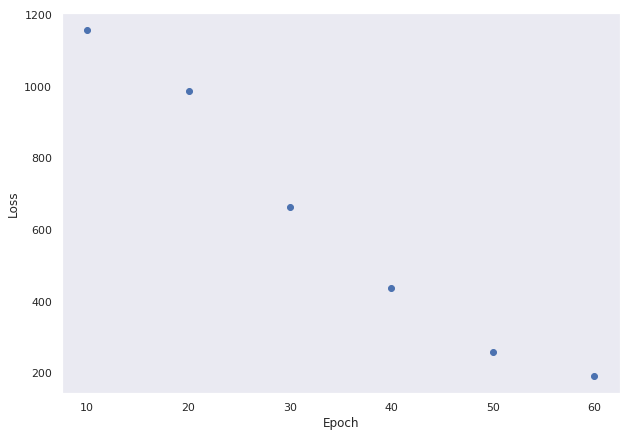

In [203]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = num_epochs
y = losses
plot.scatter(x, y)
plot

In [204]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_1 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_1["mean-roc_auc_score"])


Evaluating model
computed_metrics: [0.9968182136479815, 0.9930014008577093, 0.987694466991342, 0.9998798457656555, 0.9990129261763877, 0.9752979947174916, 0.9981600559911639, 0.9999020707583284, 0.9491632699275362, 0.9967524324436137, 0.9997345380029806, 0.9969918650861045, 0.9999799727629577, 0.9987751332364341, 1.0, 0.9993531372841717, 0.997260714142266, 0.9977326299247951, 0.9998828868394085, 0.9965135862860576, 0.9894887886367698, 0.9869837737177376, 0.995708595300551, 0.988020368317259, 0.994680544645195, 0.9987208010432088, 0.9849665243115797]
Training ROC-AUC Score: 0.993351


In [205]:
valid_scores_1 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_1["mean-roc_auc_score"])

computed_metrics: [0.5378006872852233, 0.5412844036697247, 0.4746136865342163, 0.5778523489932886, 0.5951597086018492, 0.4853951890034365, 0.5564540281521414, 0.48707416340066334, 0.5773071625344353, 0.5904306220095694, 0.5383244206773619, 0.6194326241134751, 0.6785714285714286, 0.5885311871227364, 0.625, 0.29748427672955974, 0.5633281972265023, 0.6000294204177699, 0.4905449672424062, 0.5673669467787115, 0.4851576994434137, 0.5491228070175438, 0.6007130124777184, 0.5593172119487908, 0.5471399827536649, 0.5771929824561404, 0.583178726035869]
Validation ROC-AUC Score: 0.551623


In [206]:
test_scores_1 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_1["mean-roc_auc_score"])

computed_metrics: [0.49112426035502954, 0.5170910359260551, 0.467540202501489, 0.5111261609907121, 0.5424514840182648, 0.48963317384370014, 0.48899608079589996, 0.5645302897278315, 0.49975369458128077, 0.49018817204301074, 0.5402083333333334, 0.5663446054750403, 0.48428143712574856, 0.48942028985507247, 0.4897798742138365, 0.3983221476510067, 0.5544642857142857, 0.5567765567765567, 0.5016233766233766, 0.48163723016540505, 0.4324871228844739, 0.49122807017543857, 0.5425387596899225, 0.5314062959694028, 0.466183574879227, 0.47849702380952386, 0.5091979396615158]
Validation ROC-AUC Score: 0.502846


In [207]:
num_epochs = [60,70,80,90]
losses = []

model = GraphConvModel(
    len(sideroffsides_tasks), batch_size=50, mode='classification')
# Set nb_epoch=10 for better results.


In [208]:

for i in num_epochs:
    # Set nb_epoch=10 for better results.
    loss = model.fit(train_dataset, nb_epoch=i)
    print("Epoch %d loss: %f" % (i, loss))
    losses.append(loss)

Epoch 60 loss: 760.237663
Epoch 70 loss: 397.328166
Epoch 80 loss: 249.096558
Epoch 90 loss: 474.043758


<module 'matplotlib.pyplot' from '/home/mamonteiro/anaconda3/envs/lei/lib/python3.6/site-packages/matplotlib/pyplot.py'>

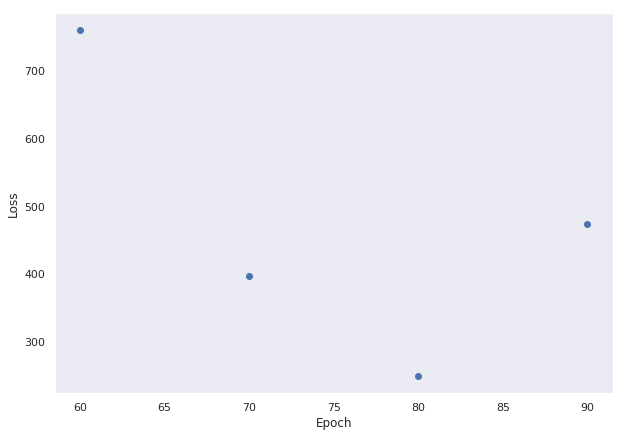

In [209]:
import matplotlib.pyplot as plot

plot.figure(figsize=(10,7))
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = num_epochs
y = losses
plot.scatter(x, y)
plot

In [210]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_2 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_2["mean-roc_auc_score"])



Evaluating model
computed_metrics: [0.9942104909958802, 0.9862000343892867, 0.9758240891053391, 0.9974294275925097, 0.9948850028176952, 0.9554158929047407, 0.9931774438721388, 0.998553318020761, 0.9137273550724638, 0.9875811568683726, 0.9992579483358173, 0.991406541897354, 0.9999799727629577, 0.9946054384689922, 0.9998985218008998, 0.9938330347813107, 0.9913731239372884, 0.9909978673251768, 0.9997950519689651, 0.9904619766356644, 0.9812148249061998, 0.977819160411959, 0.9931583184133461, 0.9757329062135142, 0.9882043728724796, 0.9927025007788226, 0.9717703189643667]
Training ROC-AUC Score: 0.986267


In [211]:
valid_scores_2 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_2["mean-roc_auc_score"])

computed_metrics: [0.4981386025200458, 0.4862385321100917, 0.5272259013980869, 0.6828859060402684, 0.5721490613617259, 0.5920675830469645, 0.5527103923330339, 0.47392221887247515, 0.5745523415977962, 0.5575757575757576, 0.5949754901960784, 0.5373049645390071, 0.7857142857142857, 0.5622305260132222, 0.6011257763975155, 0.46163522012578617, 0.548035439137134, 0.5575169167402176, 0.3980047647409172, 0.511344537815126, 0.5303030303030303, 0.6091228070175438, 0.5755347593582888, 0.5095305832147938, 0.5527450416786432, 0.5307814992025518, 0.543908472479901]
Validation ROC-AUC Score: 0.552862


In [212]:
test_scores_2 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_2["mean-roc_auc_score"])

computed_metrics: [0.5057692307692307, 0.4853505406348099, 0.44222751637879687, 0.5777863777089783, 0.5349600456621004, 0.5700159489633174, 0.4740729574917094, 0.5246927129060579, 0.48891625615763545, 0.5213709677419355, 0.5809027777777778, 0.543317230273752, 0.47604790419161674, 0.5502536231884059, 0.5117924528301887, 0.3828859060402685, 0.5284226190476189, 0.572309101155255, 0.4978354978354978, 0.43229604709840197, 0.4199779249448124, 0.4245614035087719, 0.6206395348837209, 0.5291997646366577, 0.5033816425120773, 0.4939732142857143, 0.4304635761589404]
Validation ROC-AUC Score: 0.504571


In [213]:
type(test_scores_2)
test_scores_2['mean-roc_auc_score']

0.5045712138808908

[(0.0, 0.5297997745749353)]

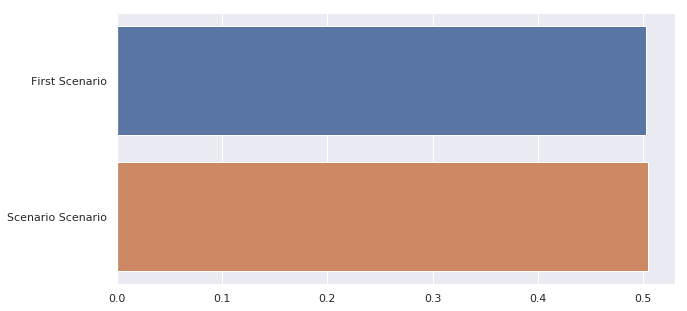

In [214]:
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score']],
                 y=['First Scenario','Scenario Scenario'])
ax.set(xlim=(0.00, None))

In [215]:
# Hiperparameters permitidos pelo deepchem e os valores que são utilizados por defeito
#/home/mamonteiro/source-code/knowledge-base/deepchem/deepchem/molnet/preset_hyper_parameters.py

In [216]:
params_dict = {'batch_size' : [32,64,128],
               'nb_epoch': [40,100],
               'learning_rate': [0.0005,0.5],
               'n_filters': [64],
               'n_fully_connected_nodes' : [64]
              }
params_dict = {'batch_size' : [32],
               'nb_epoch': [40],
               'learning_rate': [0.0005],
               'n_filters': [64],
               'n_fully_connected_nodes' : [64]
              }

In [217]:
len(train_dataset)

1352

In [218]:
n_features = len(train_dataset)

def model_builder(model_params, model_dir):
    model = GraphConvModel(
            len(sideroffsides_tasks), mode='classification',**model_params)
    
    return model



In [219]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
   params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'batch_size': 32, 'nb_epoch': 40, 'learning_rate': 0.0005, 'n_filters': 64, 'n_fully_connected_nodes': 64}
computed_metrics: [0.5684421534936999, 0.4675840978593272, 0.45217071376011775, 0.6013422818791946, 0.5771924908938078, 0.5260595647193586, 0.5112309074573225, 0.5290925535122099, 0.6201790633608817, 0.5819776714513557, 0.5655080213903743, 0.6109219858156029, 0.5595238095238095, 0.5750215579189422, 0.6840062111801242, 0.4446540880503145, 0.5616332819722649, 0.5775228008237717, 0.5300774270399047, 0.5008403361344538, 0.4802102659245516, 0.5856140350877193, 0.6205436720142603, 0.5287339971550498, 0.495688416211555, 0.5629984051036683, 0.47309833024118736]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.547847
	best_validation_score so far: 0.547847
computed_metrics: [0.8856737917673283, 0.8544555619614032, 0.8412112193362193, 0.8148059145011597, 0.9035591011552551, 0.7804427129800353, 0.887312998261212, 0.9245232626462261, 0.758455615942

In [220]:
best_dnn

GraphConvModel(dense_layer_size=128, dropout=[0.0, 0.0, 0.0],
               graph_conv_layers=[64, 64], mode='classification', n_classes=2,
               n_tasks=27, number_atom_features=75, uncertainty=False)

In [221]:
best_hyperparams

(32, 40, 0.0005, 64, 64)

In [222]:
all_results

{'(32, 40, 0.0005, 64, 64)': 0.5478469681472159}

In [223]:
###AQUI

#(32, 40, 0.0005, 64, 32)

#'batch_size' : [32,64,128,256],
#'nb_epoch': [40,100,200],
#'learning_rate': [0.0005,0.5,0.75,1],
#'n_filters': [32,64,128],
#'n_fully_connected_nodes' : [32,64,128]

#model=model_builder(params_dict,params_dict)

#model =GraphConvModel(dense_layer_size=128, dropout=[0.0, 0.0, 0.0],
#               graph_conv_layers=[64, 64], mode='classification', n_classes=2,
#               n_tasks=27, number_atom_features=75, uncertainty=False)


best_dnn.fit(train_dataset,batch_size=32,nb_epoch=10,learning_rate=0.0005,n_filters=32,n_fully_connected_nodes=32)

465.78232756355743

In [224]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores_3 = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores_3["mean-roc_auc_score"])


Evaluating model
computed_metrics: [0.9942104909958802, 0.9862000343892867, 0.9758240891053391, 0.9974294275925097, 0.9948850028176952, 0.9554158929047407, 0.9931774438721388, 0.998553318020761, 0.9137273550724638, 0.9875811568683726, 0.9992579483358173, 0.991406541897354, 0.9999799727629577, 0.9946054384689922, 0.9998985218008998, 0.9938330347813107, 0.9913731239372884, 0.9909978673251768, 0.9997950519689651, 0.9904619766356644, 0.9812148249061998, 0.977819160411959, 0.9931583184133461, 0.9757329062135142, 0.9882043728724796, 0.9927025007788226, 0.9717703189643667]
Training ROC-AUC Score: 0.986267


In [225]:
valid_scores_3 = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores_3["mean-roc_auc_score"])

computed_metrics: [0.4981386025200458, 0.4862385321100917, 0.5272259013980869, 0.6828859060402684, 0.5721490613617259, 0.5920675830469645, 0.5527103923330339, 0.47392221887247515, 0.5745523415977962, 0.5575757575757576, 0.5949754901960784, 0.5373049645390071, 0.7857142857142857, 0.5622305260132222, 0.6011257763975155, 0.46163522012578617, 0.548035439137134, 0.5575169167402176, 0.3980047647409172, 0.511344537815126, 0.5303030303030303, 0.6091228070175438, 0.5755347593582888, 0.5095305832147938, 0.5527450416786432, 0.5307814992025518, 0.543908472479901]
Validation ROC-AUC Score: 0.552862


In [226]:
test_scores_3 = model.evaluate(test_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % test_scores_3["mean-roc_auc_score"])

computed_metrics: [0.5057692307692307, 0.4853505406348099, 0.44222751637879687, 0.5777863777089783, 0.5349600456621004, 0.5700159489633174, 0.4740729574917094, 0.5246927129060579, 0.48891625615763545, 0.5213709677419355, 0.5809027777777778, 0.543317230273752, 0.47604790419161674, 0.5502536231884059, 0.5117924528301887, 0.3828859060402685, 0.5284226190476189, 0.572309101155255, 0.4978354978354978, 0.43229604709840197, 0.4199779249448124, 0.4245614035087719, 0.6206395348837209, 0.5291997646366577, 0.5033816425120773, 0.4939732142857143, 0.4304635761589404]
Validation ROC-AUC Score: 0.504571


[(0.0, 0.5297997745749353)]

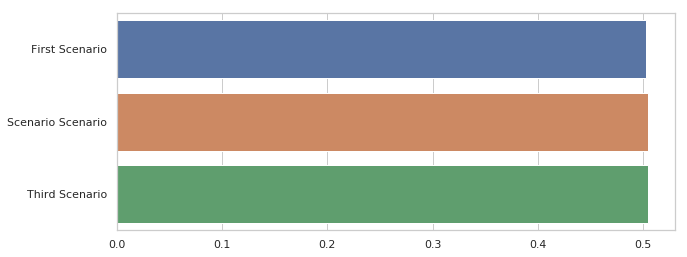

In [227]:
import seaborn as sns


sns.set(rc={'figure.figsize':(10,4)})

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score']],
                 y=['First Scenario','Scenario Scenario','Third Scenario'])
ax.set(xlim=(0.0, None))

# Another Implementation GraphConvModel

TensorGraph - Simplicity is Beauty
TensorGraph is a simple, lean, and clean framework on TensorFlow for building any imaginable models.



What’s going on under the hood? 

Now we will build GraphConvModel ourselves.

The first step is to create a TensorGraph object. 
This object will hold the “computational graph” that defines the computation that a graph convolutional network will perform.


In [228]:
from deepchem.models.tensorgraph.tensor_graph import TensorGraph
from deepchem.models.tensorgraph.layers import Dense, BatchNorm,GraphConv
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather,Dropout
import keras
import tensorflow as tf


In [229]:
tg = TensorGraph(use_queue=False)

In [230]:
from deepchem.models.tensorgraph.layers import Feature

atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)

# ver mais um atomo na tiro a camada de dropout e verifico se esta em overfitting

In [231]:
batch_size = 50

gc1 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[atom_features, degree_slice, membership] + deg_adjs)
dropout_1 = Dropout(dropout_prob=0.5, in_layers=[gc1])
batch_norm1 = BatchNorm(in_layers=[dropout_1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)

gc2 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)

gc3 = GraphConv(64,activation_fn=tf.nn.relu,in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm3 = BatchNorm(in_layers=[gc3])
gp3 = GraphPool(in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)

dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp3])
batch_norm4 = BatchNorm(in_layers=[dense])

readout = GraphGather(batch_size=batch_size,activation_fn=tf.nn.tanh,in_layers=[batch_norm4, degree_slice, membership] + deg_adjs)

In [232]:
from deepchem.models.tensorgraph.layers import Dense, SoftMax, \
    SoftMaxCrossEntropy, WeightedError, Stack

from deepchem.models.tensorgraph.layers import Label, Weights

costs = []
labels = []
for task in range(len(sideroffsides_tasks)):
    classification = Dense(out_channels=2, activation_fn=None, in_layers=[readout])

    softmax = SoftMax(in_layers=[classification])
    tg.add_output(softmax)

    label = Label(shape=(None, 2))
    labels.append(label)
    cost = SoftMaxCrossEntropy(in_layers=[label, classification])
    costs.append(cost)
    
all_cost = Stack(in_layers=costs, axis=1)
weights = Weights(shape=(None, len(sideroffsides_tasks)))
loss = WeightedError(in_layers=[all_cost, weights])
tg.set_loss(loss)

In [233]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
    for epoch in range(epochs):
        if not predict:
            print('Starting epoch %i' % epoch)
        for ind, (X_b, y_b, w_b, ids_b) in enumerate(
            dataset.iterbatches(batch_size, pad_batches=pad_batches, deterministic=True)):
            d = {}

            for index, label in enumerate(labels):
                d[label] = to_one_hot(y_b[:, index])
            d[weights] = w_b
            multiConvMol = ConvMol.agglomerate_mols(X_b)
            d[atom_features] = multiConvMol.get_atom_features()
            d[degree_slice] = multiConvMol.deg_slice
            d[membership] = multiConvMol.membership
            for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
                d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
            yield d

In [234]:
# Epochs set to 1 to render tutorials online.
# Set epochs=10 for better results.
history=tg.fit_generator(data_generator(train_dataset, epochs=10))

Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9


In [235]:
# Training dataset

In [236]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")

def reshape_y_pred(y_true, y_pred):
    """
    TensorGraph.Predict returns a list of arrays, one for each output
    We also have to remove the padding on the last batch
    Metrics taks results of shape (samples, n_task, prob_of_class)
    """
    n_samples = len(y_true)
    retval = np.stack(y_pred, axis=1)
    return retval[:n_samples]


In [237]:
print("Evaluating model")
train_predictions = tg.predict_on_generator(data_generator(train_dataset, predict=True))
train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
train_scores_4 = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)

print("----------------")
print("Training ROC-AUC Score: %f" % train_scores_4)


Evaluating model
computed_metrics: [0.5909792490925854, 0.5517078326657765, 0.5227740575396826, 0.5539802000385949, 0.5586318329106792, 0.5490719262651695, 0.5610011154489682, 0.5617477253707956, 0.5465353260869565, 0.5330193069959741, 0.6025738946845505, 0.5799841207839407, 0.6386685892814228, 0.5391147347383721, 0.6214186652234212, 0.5702810120913568, 0.5280314897377194, 0.536109552138287, 0.6171589079197775, 0.5484108658106179, 0.5469732669287118, 0.5619579411130162, 0.5494052823694328, 0.5609872158394081, 0.5413085886357685, 0.573774491559768, 0.5248092664264424]
----------------
Training ROC-AUC Score: 0.561867


In [238]:
# Validation Dataset

In [239]:
valid_predictions = tg.predict_on_generator(data_generator(valid_dataset, predict=True))
valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
valid_scores_4 = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
print("Valid ROC-AUC Score: %f" % valid_scores_4)


computed_metrics: [0.4912657502863688, 0.3796636085626911, 0.5577630610743194, 0.5939597315436241, 0.6214625945643037, 0.5091638029782359, 0.5146750524109014, 0.5049743744347301, 0.6664944903581267, 0.5478468899521531, 0.5309714795008913, 0.5312056737588653, 0.7916666666666666, 0.5106352400114975, 0.6032608695652174, 0.7220125786163523, 0.46671802773497684, 0.470873786407767, 0.4857057772483621, 0.530952380952381, 0.4372294372294372, 0.41438596491228075, 0.5109180035650625, 0.4751066856330014, 0.5326243173325669, 0.5459330143540669, 0.6385281385281385]
Valid ROC-AUC Score: 0.540222


In [240]:
# Test Dataset

In [241]:
test_predictions = tg.predict_on_generator(data_generator(test_dataset, predict=True))
test_predictions = reshape_y_pred(test_dataset.y, test_predictions)
test_scores_4 = metric.compute_metric(test_dataset.y, test_predictions, test_dataset.w)
print("Test  ROC-AUC Score: %f" % test_scores_4)

computed_metrics: [0.4976331360946745, 0.4790722009068713, 0.4466944609886837, 0.3506191950464396, 0.6000285388127854, 0.4558213716108453, 0.5102502261079288, 0.5049751243781095, 0.5135467980295567, 0.4017921146953405, 0.4222222222222223, 0.5879227053140097, 0.1467065868263473, 0.5002898550724637, 0.48553459119496856, 0.48020134228187916, 0.5095238095238095, 0.5453648915187377, 0.46926406926406933, 0.4373423044575273, 0.37398822663723325, 0.38666666666666666, 0.4499031007751938, 0.5955428067078552, 0.515780998389694, 0.5360863095238095, 0.481972038263429]
Test  ROC-AUC Score: 0.469805



# Comparision of Results with MoleculeNet results

[(0.0, 0.5297997745749353)]

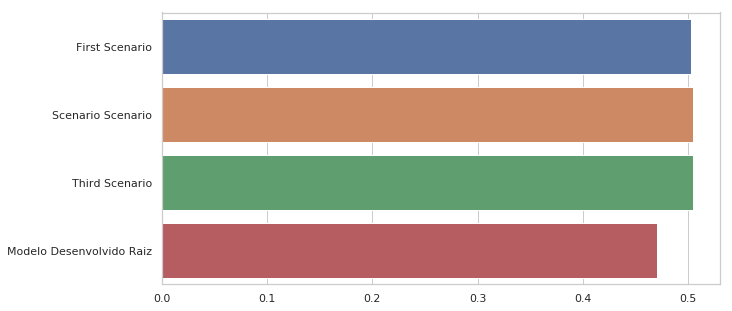

In [242]:
import seaborn as sns


sns.set(rc={'figure.figsize':(10,5)})

sns.set(style="whitegrid")
ax = sns.barplot(x=[test_scores_1['mean-roc_auc_score'],test_scores_2['mean-roc_auc_score'],test_scores_3['mean-roc_auc_score'],test_scores_4],
                 y=['First Scenario','Scenario Scenario','Third Scenario','Modelo Desenvolvido Raiz'])
ax.set(xlim=(0.0, None))

In [243]:
print(test_scores_1['mean-roc_auc_score'])

print(test_scores_2['mean-roc_auc_score'])
print(test_scores_3['mean-roc_auc_score'])
print(test_scores_4)

0.5028456103254237
0.5045712138808908
0.5045712138808908
0.4698053959744871
